# Model comparison (single step) - Matplotlib

In [1]:
# Local imports
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

from paths import PATHS
from data.base import make_splits, get_data, single_X_y

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

## Overall

In [4]:
mae = pd.read_csv("single_step/mae.csv", header=0, index_col=0)
mape = pd.read_csv("single_step/mape.csv", header=0, index_col=0)

mae = mae.sort_index(axis='index')
mape = mape.sort_index(axis='index')

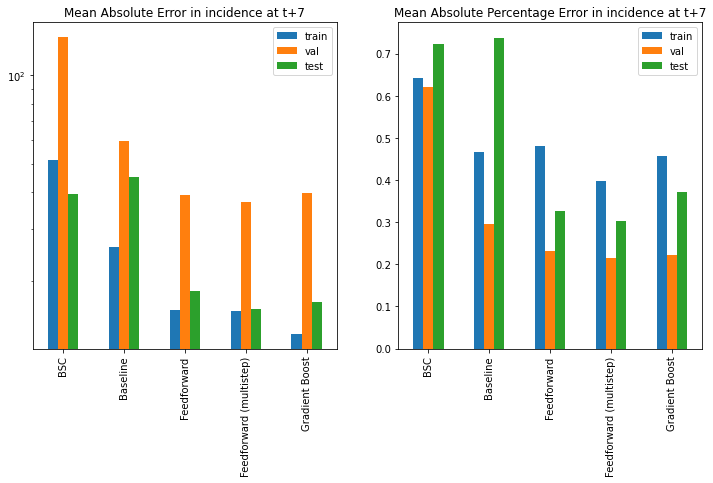

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

mae.plot.bar(ax=axs[0],
             logy=True)
axs[0].set_title("Mean Absolute Error in incidence at t+7")

mape.plot.bar(ax=axs[1])
axs[1].set_title("Mean Absolute Percentage Error in incidence at t+7")

fig.savefig('../reports/figures/single-step.png', bbox_inches='tight', dpi=150)

## Details

This section is better visualized the dash version of this notebook (`results_dash_singlestep.ipynb`)

In [4]:
df = get_data(log=True,
              trend=True)
splits = make_splits(df,
                     norm=False)
X, y = single_X_y(splits)

/home/iheredia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
# Load predictions
pred = []
for f in pathlib.Path('single_step').glob('pred_*'):
    pred.append(pd.read_csv(f, index_col=['date', 'province']))
pred = pd.concat(pred, axis=1)

### Visualize single province trend

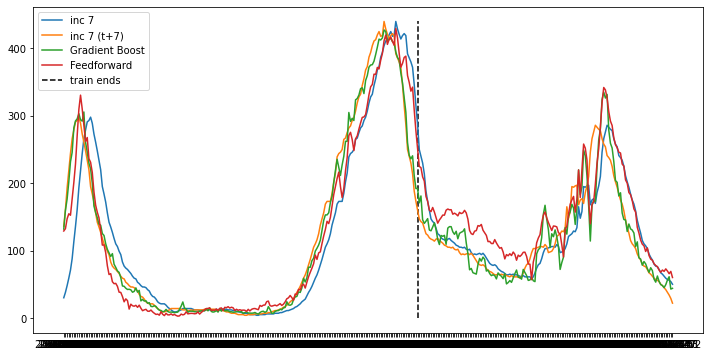

In [16]:
p = 'Madrid'
dfX = X.xs(p, level=1, drop_level=True)
dfy = y.xs(p, level=1, drop_level=True)
dfp = pred.xs(p, level=1, drop_level=True)

fig, axs = plt.subplots(figsize=(12, 6))
axs.plot(dfX['incidence 7'], label='inc 7')
axs.plot(dfy, label='inc 7 (t+7)')
for c in pred.columns:
    axs.plot(dfp[c], label=c)
    
axs.vlines('2020-10-01', 0, dfX['incidence 7'].max(), colors='k', linestyles='dashed', label='train ends')
plt.legend()

# Slightly slower
# provinces = X.index.get_level_values('province')
# idxs = (provinces == 'Madrid')
# X['incidence 7'][idxs]

### Results by provinces

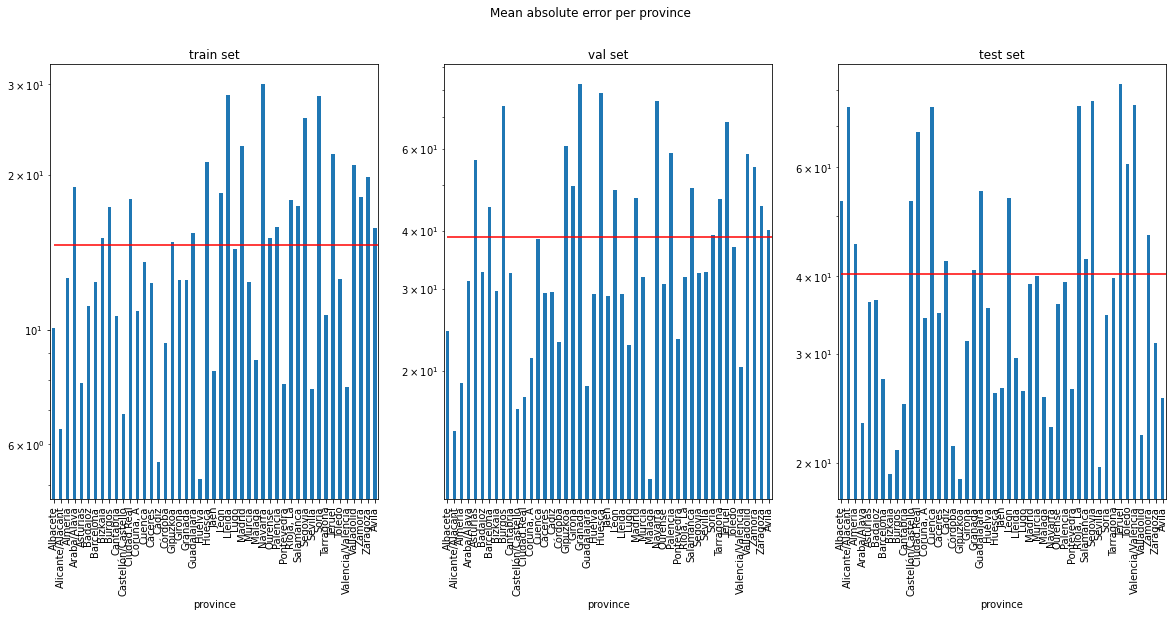

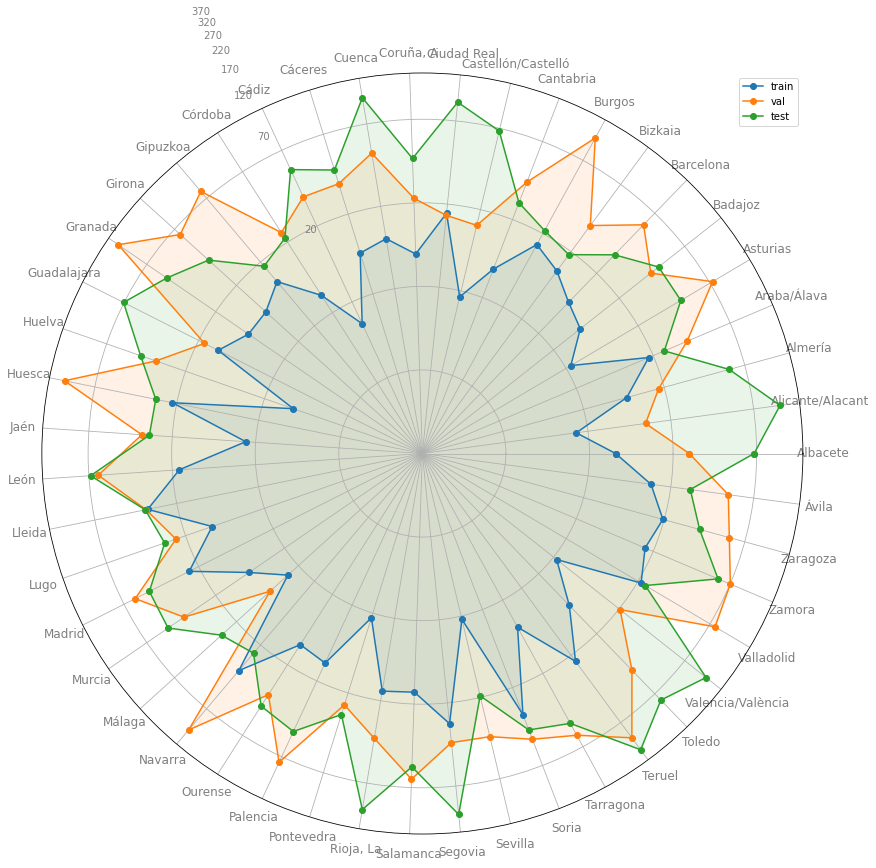

In [29]:
# model = 'Gradient Boost'
model = 'Feedforward'

# Date ranges
logscale = True
dtrain = '2020-10-01'  # end of training dataset
dval = '2020-12-01'  # end of validation dataset

dranges = {'train': dates < dtrain, 
           'val': (dates >= dtrain) & (dates < dval),
           'test': dates >= dval}

diff = np.abs(y.iloc[:, 0] - pred[model])

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 14), subplot_kw={'projection': 'polar'})

for i, j in enumerate(['train', 'val', 'test']):
    d = diff[dranges[j]].unstack()
    m = d.mean()
    
    # Bar plot
    m.plot.bar(ax=axs[i])
    axs[i].hlines(d.mean().mean(), 0, len(provinces), 'r')
#     sns.violinplot(data=x, ax=axs)
#     _ = plt.xticks(rotation=90)
    axs[i].set_title(f'{j} set')
    axs[i].set_yscale('log')
    
    # Radar plot
    if logscale:
        m = np.log(m)
    theta = np.arange(len(m) + 1) / len(m) * 2. * np.pi
    values = np.append(m, m[0])

    l1, = ax1.plot(theta, values, color=f'C{i}', marker='o', label=j)
    plt.xticks(theta[:-1], m.index, color='grey', size=12)
    ax1.tick_params(pad=10)
    ax1.fill(theta, values, f'C{i}', alpha=0.1)
    
if logscale:
    for r in range(20, 400, 50):
        ax1.text(90, np.log(r), r, color='grey', ha='center', va='center')
    ax1.set_yticklabels([])

fig.suptitle('Mean absolute error per province')
plt.legend()
# plt.show()